# Problem Statement
Singapore is an ideal environment for mosquito breeding with high temperatures and high humidity. It is a densely populated city with a total land area of 728.6 square kilometres and over 5 million people, and building boom and population growth have caused the increase in dengue cases. Three million of Singapore residents live in HDB flats and this increased human population density aided the spread of dengue.

In [5]:
# Import relevant libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from keras.layers import SimpleRNN
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

## Data Collection

In [6]:
# Import the dengue data
dengue = pd.read_csv('./assets/weekly_cases_10_years.csv')

In [7]:
print(dengue.shape)
dengue.head()

(20070, 3)


,epi_week,disease,no._of_cases
0,2012-W01,Acute Viral hepatitis B,0
1,2012-W01,Acute Viral hepatitis C,0
2,2012-W01,Avian Influenza,0
3,2012-W01,Campylobacterenterosis,6
4,2012-W01,Chikungunya Fever,0


## Data Cleaning and Preprocessing

In [8]:
# Find out what are the unique values in the disease column
dengue['disease'].unique()

array(['Acute Viral hepatitis B', 'Acute Viral hepatitis C',
       'Avian Influenza', 'Campylobacterenterosis', 'Chikungunya Fever',
       'Cholera', 'Dengue Fever', 'Dengue Haemorrhagic Fever',
       'Diphtheria', 'Encephalitis', 'Haemophilus influenzae type b',
       'Hand, Foot Mouth Disease', 'Legionellosis', 'Malaria', 'Measles',
       'Melioidosis', 'Meningococcal Infection', 'Mumps',
       'Nipah virus infection', 'Paratyphoid', 'Pertussis', 'Plague',
       'Pneumococcal Disease (invasive)', 'Poliomyelitis', 'Rubella',
       'Salmonellosis(non-enteric fevers)', 'SARS', 'Typhoid',
       'Viral Hepatitis A', 'Viral Hepatitis E', 'Yellow Fever',
       'Zika Virus Infection', 'Acute Viral Hepatitis A',
       'Acute Viral Hepatitis E', 'Chikungunya', 'HFMD', 'Nipah',
       'Campylobacter enteritis', 'Leptospirosis', 'Zika',
       'Ebola Virus Disease', 'Japanese Encephalitis', 'Tetanus',
       'Botulism', 'Murine Typhus', 'Monkeypox'], dtype=object)

In [9]:
# Filter the data to only show the dengue diseases
dengue = dengue[(dengue['disease'] == 'Dengue Fever') | (dengue['disease'] == 'Dengue Haemorrhagic Fever')]

In [10]:
dengue.head()

,epi_week,disease,no._of_cases
6,2012-W01,Dengue Fever,74
7,2012-W01,Dengue Haemorrhagic Fever,0
37,2012-W02,Dengue Fever,64
38,2012-W02,Dengue Haemorrhagic Fever,2
68,2012-W03,Dengue Fever,60


In [11]:
# Check if all filtered data are only for dengue
dengue['disease'].unique()

array(['Dengue Fever', 'Dengue Haemorrhagic Fever'], dtype=object)

In [12]:
# The epi_week contains "W", hence, need to remove to allow it to be in year-week format
dengue.loc[:, 'epi_week'] = dengue['epi_week'].apply(lambda x: x[:5] + x[6:])
dengue.head()

,epi_week,disease,no._of_cases
6,2012-01,Dengue Fever,74
7,2012-01,Dengue Haemorrhagic Fever,0
37,2012-02,Dengue Fever,64
38,2012-02,Dengue Haemorrhagic Fever,2
68,2012-03,Dengue Fever,60


Syntax note: 
1. `dengue.loc[:, 'epi_week']` is used over `dengue['epi_week']` because `loc` explicitely tells pandas that the original dataframe is to be modified. When `dengue['epi_week']` is used, a `SettingsWithCopyWarning` is thrown by pandas. This warning is raised when I try to modify the df, but pandas is unsure if I am modifying the original df or modifying a copy of the df.

2. Reassigning dengue df back to itself after columns have been dropped and renamed (instead of using `inplace=True`) to avoid `SettingsWithCopyWarning` too.

In [13]:
# Remove the disease column as all are considered dengue cases
dengue = dengue.drop(columns = 'disease')

# Rename no of cases and epi week column
dengue = dengue.rename(columns = {'no._of_cases' : 'cases', 'epi_week' : 'date'})

In [14]:
dengue.head()

,date,cases
6,2012-01,74
7,2012-01,0
37,2012-02,64
38,2012-02,2
68,2012-03,60


In [15]:
# Convert the date column from year-week to year-month-date format

# Function to convert year-week format to date
def year_week_to_date(year_week):
    year, week = map(int, year_week.split('-'))
    # Assuming week starts from Monday
    return datetime.strptime(f'{year}-{week}-1', "%Y-%W-%w")

# Convert year-week to date
dengue['date'] = [year_week_to_date(date_str) for date_str in dengue['date']]

In [16]:
dengue.head()

,date,cases
6,2012-01-02,74
7,2012-01-02,0
37,2012-01-09,64
38,2012-01-09,2
68,2012-01-16,60


In [17]:
# Combine the cases that happen on the same date
dengue = dengue.groupby('date').sum()
dengue.head()

,cases
date,
2012-01-02,74
2012-01-09,66
2012-01-16,61
2012-01-23,52
2012-01-30,85


In [18]:
# Modify the data into monthly
dengue = dengue.resample('M').sum()

In [19]:
dengue.head()

,cases
date,
2012-01-31,338
2012-02-29,258
2012-03-31,231
2012-04-30,363
2012-05-31,338


## Exploratory Data Analysis

### Dengue Trend Across Years

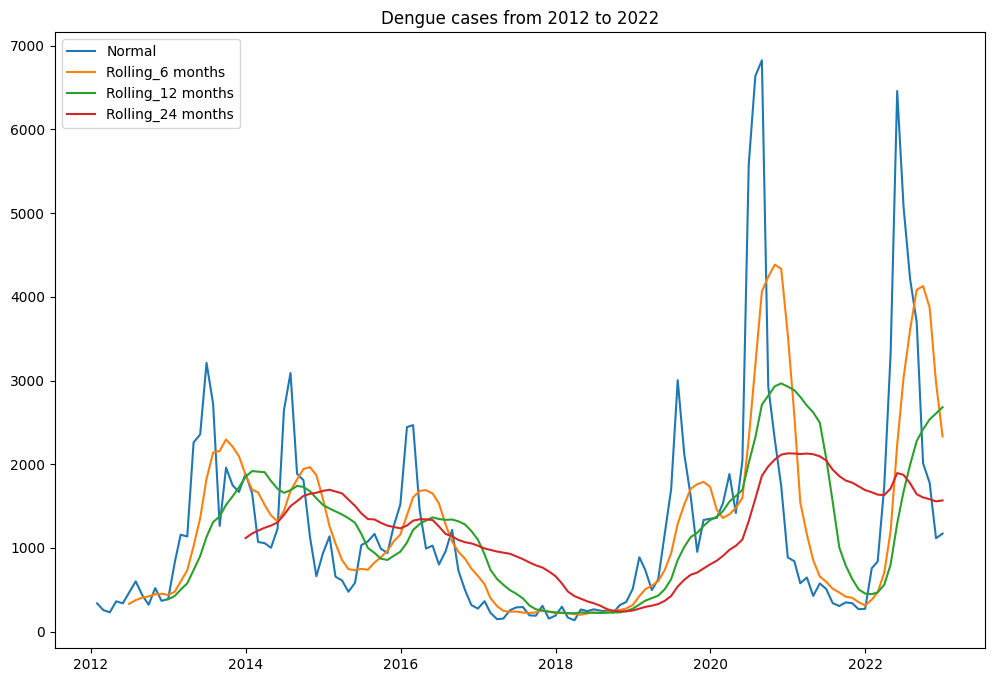

In [20]:
plt.figure(figsize=(12,8))
windows = [0, 6, 12, 24]
for window in windows:
    if window == 0:
        plt.plot(dengue['cases'], label='Normal')
    else:
        plt.plot(dengue['cases'].rolling(window).mean(), label=f'Rolling_{window} months')
plt.title('Dengue cases from 2012 to 2022')
plt.legend();

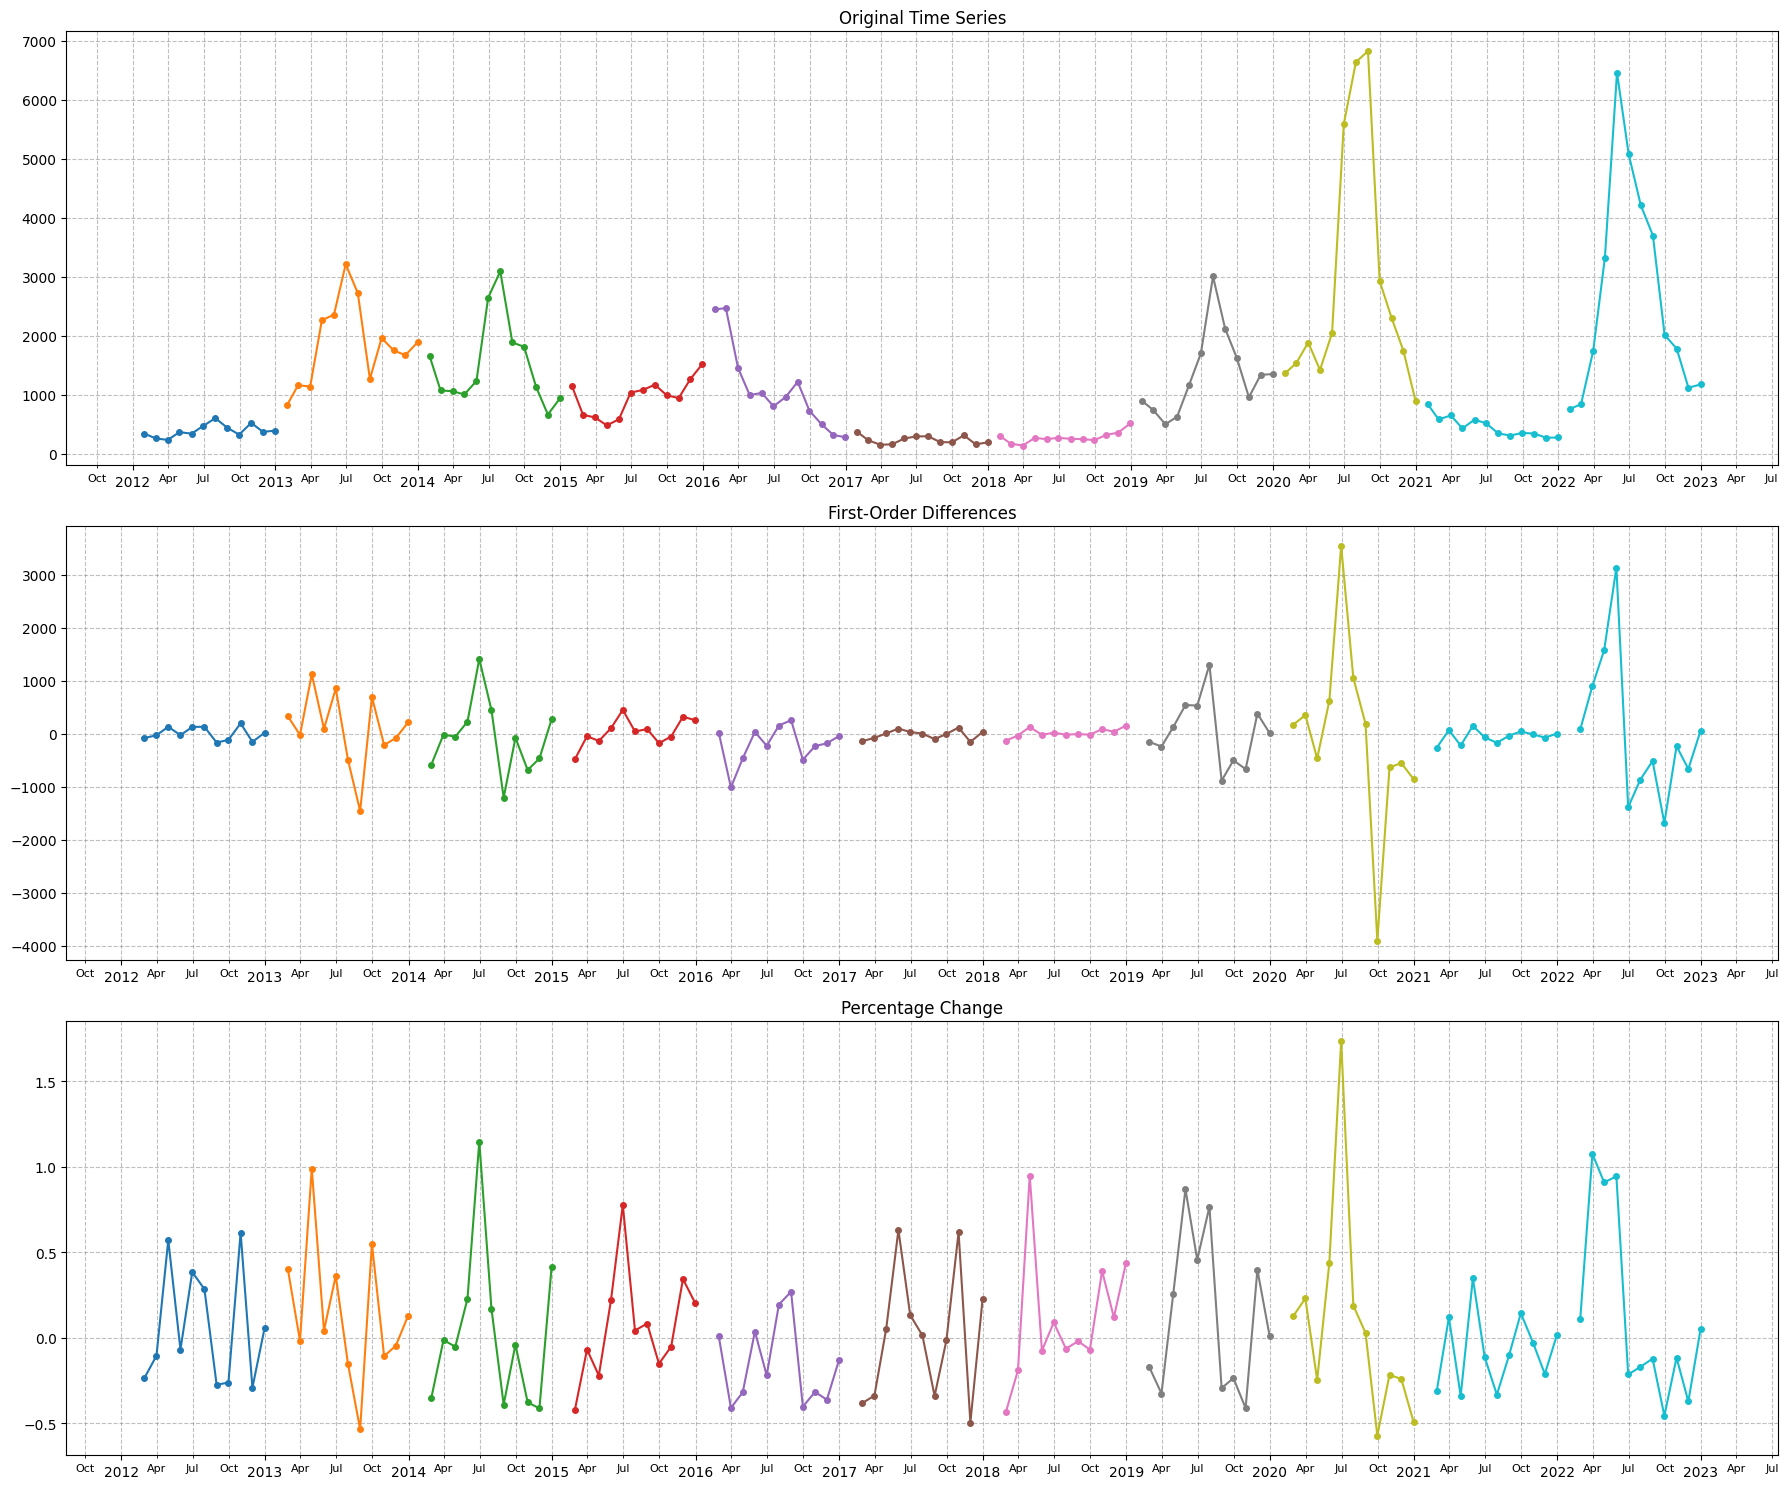

In [21]:
fig, axes = plt.subplots(nrows=3, figsize=(18,15))

# Define the marker size, colormap 
marker_size = 4
cmap = plt.get_cmap('tab10')

titles = ['Original Time Series', 'First-Order Differences', 'Percentage Change']
unique_years = dengue.index.year.unique()

for index, title in enumerate(titles):
    for i, year in enumerate(unique_years):
        mask = dengue.index.year == year
        
        if title == 'Original Time Series':
            plot = dengue['cases'][mask]
        elif title == 'First-Order Differences':
            plot = dengue['cases'][mask].diff()
        elif title == 'Percentage Change':
            plot = dengue['cases'][mask].pct_change()
        
        axes[index].plot(dengue.index[mask], plot, marker='o', markersize=marker_size, linestyle='-', color=cmap(i))
        axes[index].set_title(titles[index])
        
        # Setting common x-axis formatting
        axes[index].xaxis.set_major_locator(YearLocator())
        axes[index].xaxis.set_minor_locator(MonthLocator(bymonth=(1, 4, 7, 10)))  # Minor ticks at the start of each quarter
        axes[index].xaxis.set_major_formatter(DateFormatter('%Y'))  # Format: Year
        axes[index].xaxis.set_minor_formatter(DateFormatter('%b'))  # Format: Abbreviated month
        axes[index].grid(True, which='both', linestyle='--', color='gray', alpha=0.5) #add gridlines

        plt.setp(axes[index].xaxis.get_minorticklabels(), fontsize=8) # Rotating x-axis labels for better readability

plt.tight_layout()

In [26]:
# Evaluate the diff and pct change
dengue['diff'] = dengue['cases'].diff()
dengue['pct_change'] = dengue['cases'].pct_change()
dengue.head()

,cases,diff,pct_change
date,,,
2012-01-31,338,NaN,NaN
2012-02-29,258,-80.0,-0.236686
2012-03-31,231,-27.0,-0.104651
2012-04-30,363,132.0,0.571429
2012-05-31,338,-25.0,-0.068871


In [27]:
# Create an empty list to store individual DataFrames
dfs = []

# Iterate over unique years in the index of the DataFrame
for year in dengue.index.year.unique():
    # Filter data for the current year
    data_for_year = dengue[dengue.index.year == year]
    # Find the row with the maximum number of cases for the current year
    max_row = data_for_year.loc[data_for_year['cases'].idxmax()]
    min_row = data_for_year.loc[data_for_year['cases'].idxmin()]
    # Extract the date and maximum cases for the current year
    max_month = max_row.name.strftime('%b')
    max_cases = max_row['cases']
    min_month = min_row.name.strftime('%b')
    min_cases = min_row['cases']
    # Create a DataFrame for the current year's maximum cases
    df = pd.DataFrame({'year': year, 'highest_month': max_month, 'highest_cases': max_cases, 'lowest_month': min_month, 'lowest_cases': min_cases}, index=[0])
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate all DataFrames in the list
result_df = pd.concat(dfs, ignore_index=True)

# Display the result DataFrame
print(result_df)

    year highest_month  highest_cases lowest_month  lowest_cases
0   2012           Jul          601.0          Mar         231.0
1   2013           Jun         3211.0          Jan         825.0
2   2014           Jul         3090.0          Nov         662.0
3   2015           Dec         1520.0          Apr         477.0
4   2016           Feb         2467.0          Dec         276.0
5   2017           Jan          364.0          Mar         149.0
6   2018           Dec          511.0          Mar         136.0
7   2019           Jul         3004.0          Mar         497.0
8   2020           Aug         6825.0          Dec         887.0
9   2021           Jan          841.0          Nov         268.0
10  2022           May         6458.0          Jan         757.0


According to an article by NCID, dengue in Singapore typically rises in warmer months, from April, peaking in July or August, before declining in September or October. Abnormal climate changes, such as the El Niño weather phenomenon, may affect the mosquito breeding environment, accelerate the life-cycle of Aedes mosquito, shorten the incubation period of the dengue virus and drive up cases. The warmer months from June to October usually see higher transmission of dengue in Singapore, due to accelerated development of the Aedes mosquito and shorter incubation period of the Dengue virus.

#### 2013 - 2015
As published in the journal by MOH, a large epidemic stretching over two years in 2013 - 2014 were associated with a switch in the main dengue virus serotype from serotype 2 (DENV-2) to serotype 1 (DENV-1) and the emergence of a
new strain of DENV-1 virus with apparently greater fitness. 

The third year of this period, 2015, saw a drastic drop in dengue cases which was attributed to 
- The sentinel surveillance system whereby gravitraps were deployed in HDB housing estates
- Ramping up of the inspection of some premises and surveyed over thousands of outdoor areas
- Population built immunity towards DENV-1 serotype



#### 2016
According an article published by NEA, in early 2016, NEA alerted the community of a possible outbreak following a switch in predominant serotype from DENV-1 to DENV-2. Despite an early surge in the number of cases early in 2016, the situation was brought under control and remained low for the rest of the year. This was attributed to:
- Community effort to actively remove mosquito breeding habitats 
- Million of inspections conducted by NEA that uncovered mosquito breeding habitats at housing estates and construction sites

#### 2017 - 2018
There were number of dengue cases in Singapore but it is the lowest figure in the past several years with no uptick of cases observed. NEA attributed the relatively low number to:
- Population has built up immunity after a high number of cases from 2013-2014 and early 2016
- Community and NEA effort to step up the inspection and remove the uncovered mosquito breeding habitats
- Implementation of network of Gravitrap surveillance system that catch Aedes aegypti mosquitos and collect data on them

#### 2019 - 2022
In 2019, piror to Covid-19, there was an uptick of dengue cases in July which was attributed to the sustained change in the predominant dengue virus serotype of DENV-3 and the warmer months of June to October period.

In 2020, a resurgence of epidemic dengue was observed during the COVID-19 pandemic with the highest ever annual incidence reported in Singapore. A sharp upward trend was observed in 2020 and reached its peak in July 2020, and this was attributed to:
- The rise of DENV-3 and DENV-4 in which neither serotypes have infected large numbers of people in the past
- Higher humidity and warmer temperatures in 2020
- The work-from-home arrangement to allow social distancing has led to most people working from naturally ventilated homes, rather than offices, shops and factories. This increased the probability of contact between Aedes aegypti mosquitoes and humans

The peak in July 2020 followed by a sharp decline as community rallied together to fight dengue which includes residents checking their homes frequently for potential mosquito breeding habitats, and using insect repellent and insecticides to protect themselves and families. Government also step up inspections and vector control operations in the common areas of estates

In 2021, the dengue cases remained relatively stable which likely due to:
- Temporary cross-protective immunity arising from the large dengue oubtreak from 2019 to 2020
- Launching of the annual National Dengue Prevention Campaign and usage of social media and chat platforms to raise greater awareness of dengue prevention
- Under-reporting due to the overwhelming demands of handling the COVID-19 pandemic which might have seen dengue monitoring drop to a lesser priority in some places

However, 2022 saw a resurgence of dengue cases, which likely attributed to:
- The waning of the cross-protective immunity
- Higher mosquito population which might be due to increased construction in 2022 and warmer climate conditions that have shortened the incubation cycles of the mosquito
- Circulation of the less-common DENV-3 serotype which the population here has lower immunity against

## Evaluation

LSTM model did better than RNN because during backpropagation, RNNs suffer from the vanishing gradient problem, where the gradient can become very small and the weights of the neurons are not effectively updated. This makes it difficult for an RNN to learn and capture long-term dependencies in the data. LSTM networks, with their gating mechanisms, are designed to combat this problem.

LSTMs also have input, forget and output gates. These gates determine what information should be kept or discarded from the cell state, which allows the LSTM to maintain a kind of "long-term memory".

# Recommendation with Cost-Benefit Analysis

## Economic Impact of Dengue

### Direct Cost
Direct costs were calculated from the cost incurred for consultation and hospitalization.

#### Consultation
According to MOH and Singapore Medical Association , some costs that might be incurred due to dengue fever are as follows:
- Blood test to determine if it is dengue fever, cost SGD 80
- Regular consultation fee with GP, cost SGD 50
- Assume medication fee of SGD 50
- In total, one consultation and blood test costs SGD 180

In [28]:
consultation_fee = 180

#### Hospitalization
According to MOH, between 12% and 22% of dengue patients over the past three years were hospitalised. For our evaluation, we take the middle value, which is 17% as the proportion of people that are hospitalized due to dengue.

Data published by MOH shows the following details for Dengue hospitalization:
- Average hospital fee of SGD 6,000
- Average length of stay of 3 days
- Doctor's attendance fee of SGD 1,000 throughout the 3 days
- In total, one hospitalized dengue case costs SGD 7,000

In [29]:
percentage_hospitalization = 0.17
hospitalization_fee = 7000

### Indirect Cost
Indirect costs were expressed per unspecified day and included the reduction of work productivity and the time required to provide caretaking to children and elderly

#### Reduction in Work Productivity
We calculate and quantify by using the years of healthy life lost due to dengue. In this case, based on NEA, typically dengue fever lasts for up to 1 week. Therefore, one dengue impacts 0.02 of annual workers time to be unavailable for work.

To calculate the cost impact, we take the median gross annual income from MOM website. In 2023, the median gross monthly income is SGD 5,197 which makes the gross annual income of 12 x SGD 5,197 = SGD 62,364.

In conclusion, one dengue on a worker impacts a cost of 0.02 * SGD 62,364 = SGD 1,250

In [30]:
work_impact = 1250
percentage_work = 0.8

#### Children and Elderly Caretaking
We assumed that symptomatic children and elderly caused further parental/child job absenteeism from caretaking. We will assume that working adult will take 2 days per children or elderly that caught dengue as the critical phase of dengue lasts for 24 - 48 hours.

This 2 days off work equivalent to 2/365 = 0.005 of the annual workers time.

In conclusion, one dengue case on children or elderly will result in a cost of 0.005 * SGD 62,364 = SGD 320

In [31]:
caretaking_impact = 320

### Calculating the Cost Impact

#### Total Dengue Cases per Year
To get the total number of dengue cases per year, we will take the recent case on 2022

In [32]:
dengue.resample('Y').sum()

,cases,diff,pct_change
date,,,
2012-12-31,4632,51.0,0.673678
2013-12-31,22194,1496.0,2.738103
2014-12-31,18168,-948.0,0.200138
2015-12-31,11461,583.0,0.970218
2016-12-31,13179,-1244.0,-1.041177
2017-12-31,2776,-85.0,0.421479
2018-12-31,3285,320.0,1.692948
2019-12-31,15998,838.0,2.060137
2020-12-31,35121,-462.0,0.989535


In [33]:
dengue_case = 32175

### Total Economic Impact

#### Direct Cost

In [34]:
direct_cost = (dengue_case * (1-percentage_hospitalization) * consultation_fee) + (dengue_case * percentage_hospitalization * hospitalization_fee)
direct_cost

43095195.0

#### Indirect Cost

In [35]:
indirect_cost = (dengue_case * percentage_work * work_impact) + (dengue_case * (1 - percentage_work) * caretaking_impact)
indirect_cost

34234200.0

#### Total Cost Impact

In [36]:
total_cost = direct_cost + indirect_cost
total_cost

77329395.0

In [37]:
print(f'The total cost impact from dengue is estimated to be SGD {round(total_cost/1000000, 2)} million')

The total cost impact from dengue is estimated to be SGD 77.33 million


## Dengue Prevention Program

### Project Wolbachia
This is a vector control programme where it involves the release of non-biting male Wolbachia-carrying mosquitoes to mate with urban female mosquitoes. When female mosquitoes from the field – which do not carry Wolbachia – mate with males that carry Wolbachia, the eggs derived from these matings do not hatch. Theoretically, releasing males carrying Wolbachia could lead to a reduction in the population of Aedes mosquitoes in the field.

#### How Does Wolbachia-Aedes Suppression Technology Work?
- When male Wolbachia-carrying Aedes aegypti (Wolbachia-Aedes) mosquitoes mate with urban female Aedes aegypti that do not carry Wolbachia, their resulting eggs do not hatch.
- Over time, continued releases of male Wolbachia-Aedes mosquitoes will lead to a decline in urban Aedes aegypti populations. This not only reduces the risk of dengue, but also of other Aedes aegypti-borne diseases such as Zika and chikungunya. 

#### Facts around Wolbachia Program
- Wolbachia is a safe, naturally occurring bacterium found in more than 60% of insect species, including butterflies, bees, dragonflies and some species of mosquitoes
- Wolbachia DOES NOT harm humans or animals. Humans and animals have always been exposed to Wolbachia. This happens when they come into contact with insects, eat insects, or eat foods such as fruit that are exposed to insects.
- Negligible risk from unintentional release of female Wolbachia-Aedes mosquitoes. Unintentional release of large numbers of female Wolbachia-Aedes is avoided with laboratory security and robust sex-sorting processes
- Male mosquitoes do not bite or transmit disease. Male mosquitoes feed only on plant juices, such as nectar, to get the sugar they need for energy and survival. Female mosquitoes, on the other hand, need protein from blood for the development of their eggs.

#### Implementation of Wolbachia
- Phase 1 (2016 - 2017): Small-scale releases in Braddell Heights (landed residential area) and Tampines West and Nee Soon East (HDB). These sites are representative of housing estates in Singapore, and had previously experienced dengue outbreaks and high Aedes aegypti populations. Result: Egg hatch rates and adult Aedes aegypti populations in release sites were reduced by **50%** compared to sites with no releases.
- Phase 2 (2018 - 2019): Carried out in Tampines West and Nee Soon East, high-floor releases in addition to ground-floor releases. Result: **70-80%** suppression of the Aedes aegypti mosquito population in the release sites
- Phase 3 (2019): Tampines West and Nee Soon East study sites were further expanded  to determine if suppression could be sustained over larger areas. Result: **>90%** suppression of the Aedes aegypti mosquito population in the study sites, again suggesting that larger sites yield better results.

- Phase 4 (2019 - 2020): Cover more areas in Tampines and Yishun. Result: **65-80%** less dengue cases in the Tampines and Yishun release sites, compared to areas without release.
- Phase 5 (2020 - 2022): Gradually expand to the entire HDB towns of Yishun and Tampines. Result: Up to **88%** of reduction in dengue cases was observed at core areas of the study sites with at least one year of releases.

- Future plan to expand releases of male Wolbachia-carrying Aedes aegypti mosquitoes (Wolbachia-Aedes) to cover more areas and study sites

#### Implementation at Other Countries
- Trial in Yogyakarta in Indonesia showed a 77% reduction in dengue cases and an 86% reduction in dengue hospitalisations in Wolbachia-treated areas compared with untreated areas.
- In a case control study in Medellin, Colombia in 2019-2021, dengue incidence was reduced by 50% among participants resident in Wolbachia-treated neighbourhoods.
- Following regular dengue outbreaks each year 2016-2019, there have been no dengue outbreaks in Nouméa since Wolbachia deployments commenced.

#### Cost of Wolbachia Implementation
Research suggests implementation cost for the whole of Singapore is SGD 40 million

In [39]:
wolbachia_cost = 40

#### Conclusion
Project Wolbachia, if implemented could potentially bring down at least **70%** of dengue cases, as shown in the multiple phases of the NEA implementation. Other countries that implemented Wolbachia program also saw similar reduction in the number of dengue cases

In [38]:
percentage_reduction = 0.7

## Cost-Benefit Calculation

In [40]:
benefit = (percentage_reduction * total_cost) - wolbachia_cost
benefit

54130536.5

In [42]:
print(f'The benefit of implementing Wolbachia program to the entire Singapore is calculated to be SGD {round(benefit/1000000)} million annually')

The benefit of implementing Wolbachia program to the entire Singapore is calculated to be SGD 54 million annually


# Source

https://www.moh.gov.sg/docs/librariesprovider5/resources-statistics/reports/vector-borne--zoonotic-diseases.pdf

https://www.ncid.sg/Health-Professionals/Articles/Pages/Rise-in-dengue-cases-underscores-need-for-constant-vigilance.aspx.

https://www.nea.gov.sg/media/news/news/index/nea-urges-continued-vigilance-to-avoid-surge-in-dengue-cases-in-2017

https://www.straitstimes.com/singapore/2772-dengue-cases-in-2017-the-lowest-in-the-last-16-years-nea

https://www.nea.gov.sg/media/news/news/index/nea-brings-forward-national-dengue-prevention-campaign-and-rolls-out-additional-new-tools-to-combat-dengue-with-increasing-evidence-of-a-sustained-switch-in-dengue-virus-serotype

https://www.ncid.sg/Health-Professionals/Articles/Pages/Epidemic-Dengue-in-Singapore-During-COVID-19-Pandemic.aspx

https://www.nea.gov.sg/integrated-sustainability-report-2021-2022/review-of-fy2021/ensuring-a-clean-and-sustainable-environment-for-singapore/high-standards-of-public-health#:~:text=Singapore%20reported%20a%20significant%20decrease,outbreak%20from%202019%20to%202020.

https://www.channelnewsasia.com/asia/dengue-fever-plummet-southeast-asia-2021-covid-19-lockdown-1949581

https://journals.plos.org/plosntds/article?id=10.1371/journal.pntd.0001848

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6327938/